In [3]:
import pandas as pd
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
sys.path.append('../../')

from scoring.event_detection_matrix import competition_score
from tqdm import tqdm

## Daten laden

In [66]:
predictions = pd.read_parquet('./data/predicted_series.parquet')
validation_events = pd.read_csv('../../data/processed/validation_events_split.csv')

In [130]:
predictions['series_id'] = predictions['num_series_id']

In [131]:
predictions.dtypes

step                         int64
num_series_id                int64
awake                        int64
prediction_class             int64
prediction_confidence_0    float64
prediction_confidence_1    float64
series_id                    int64
correct_prediction           int64
dtype: object

In [132]:
predictions['correct_prediction'] = (predictions['awake'] == predictions['prediction_class']).replace({True: 1, False: 0})

## Event Extraction

In [133]:
def get_events_smoothed(test_series) :
    series_ids = test_series['num_series_id'].unique()
    events = []

    for idx in tqdm(series_ids):
        # Collecting sample and normalizing features
        X = test_series[test_series.num_series_id == idx]
                
        smoothing_length = 12 * 30 # 30 Minutes
        # We average the confidence, that the participant is awake
        X["confidence_awake"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
        X["asleep"] = X["prediction_confidence_0"].rolling(smoothing_length, center=True).mean().bfill().ffill()

        # Binarize the asleep column
        X["asleep"] = X["asleep"].round()

        # Getting predicted onset and wakeup time steps
        pred_onsets = X[X['asleep'].diff() > 0]['step'].tolist() # diff is > 0 if it changes from 0 (awake) to 1 (asleep)
        pred_wakeups = X[X['asleep'].diff() < 0]['step'].tolist() # diff is < 0 if it changes from 1 (asleep) to 0 (awake)
     
        if len(pred_onsets) > 0:

            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets):
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups):
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods:
                # We take the score
                score = 1 - X[(X['step'] >= onset) & (X['step'] < wakeup)]['confidence_awake'].mean()

                # Adding sleep event to dataframe
                onset_row = {'row_id': len(events), 'series_id': idx, 'step': onset, 'event': 'onset', 'score': score}                
                events.append(onset_row)

                wakeup_row = {'row_id': len(events), 'series_id': idx, 'step': wakeup, 'event': 'wakeup', 'score': score}
                events.append(wakeup_row)

    return pd.DataFrame(events)

In [134]:
predicted_events = get_events_smoothed(predictions)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16032\2987299727.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16032\2987299727.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Michael Jakober\AppData\Local\Temp\ipykernel_16032\2987299727.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of 

In [135]:
sample = predictions[predictions.num_series_id == 21]

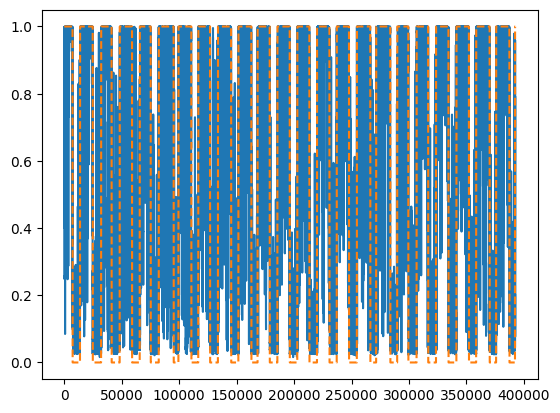

In [136]:
plt.plot(sample['step'], sample['prediction_confidence_1'])
plt.plot(sample['step'], sample['awake'], linestyle='dashed')
plt.show()

## Accuracy pro Serie

In [137]:
series = predictions.series_id.unique()

In [138]:
[*range(1, len(series) + 1, 1)]

[1, 2]

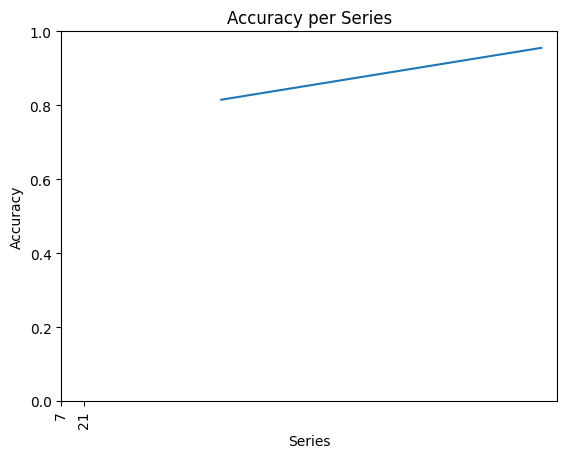

In [139]:
ax = predictions.groupby('series_id')['correct_prediction'].mean().sort_values().plot(
    ylim=(0, 1), title='Accuracy per Series'
)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Series")
ax.set_xticks(ticks=[*range(0, len(series), 1)], labels=series, rotation=90)

fig = ax.get_figure()
fig.savefig("accuracy-per-series.png", bbox_inches="tight")

In [140]:
predictions.groupby('series_id')['correct_prediction'].mean().sort_values()

series_id
7     0.815452
21    0.955749
Name: correct_prediction, dtype: float64

## Competition Score pro Serie

In [141]:
validation_events['series_id'] = validation_events['num_series_id']

In [145]:
predicted_events.series_id

0       7
1       7
2       7
3       7
4       7
       ..
137    21
138    21
139    21
140    21
141    21
Name: series_id, Length: 142, dtype: int64

In [146]:
series_ids = predicted_events.series_id.unique()
scores = []

for series_id in tqdm(series_ids):
    predicted_events_series = predicted_events[predicted_events.series_id == series_id]
    true_events_series = validation_events[validation_events.series_id == series_id]

    score = competition_score(true_events_series, predicted_events_series)
    
    scores.append({'series_id': str(series_id), 'score': score})

scores = pd.DataFrame(scores)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.56it/s]


In [147]:
scores = scores.sort_values('score')

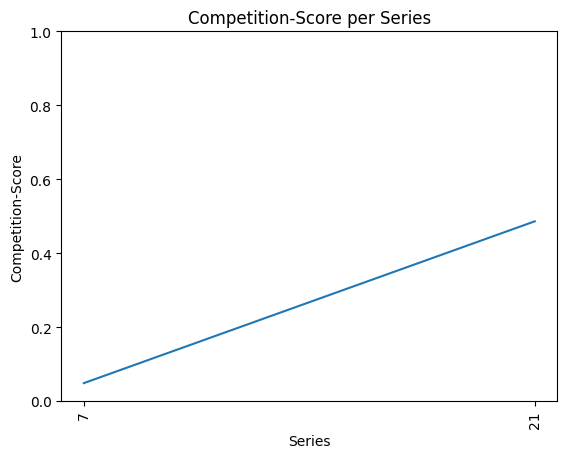

In [149]:
ax = scores.groupby('series_id')['score'].mean().sort_values().plot(
    ylim=(0, 1), title='Competition-Score per Series'
)
ax.set_ylabel("Competition-Score")
ax.set_xlabel("Series")
ax.set_xticks(ticks=[*range(0, len(series), 1)], labels=series, rotation=90)

fig = ax.get_figure()
fig.savefig("accuracy-per-series.png", bbox_inches="tight")

## Daten visualisieren

In [161]:
participant_series_id = 7
participant_series = predictions[predictions.series_id == participant_series_id]
participant_series = participant_series[0:100_000]

participant_events = predicted_events[predicted_events.series_id == participant_series_id]
participant_events = participant_events[0:12]

participant_true_events = validation_events[validation_events.series_id == participant_series_id]
participant_true_events = participant_true_events[0:12]

In [162]:
participant_series

step  num_series_id  awake  prediction_class  prediction_confidence_0  \
0          0              7      1                 1                 0.131363   
1          1              7      1                 1                 0.135859   
2          2              7      1                 1                 0.046935   
3          3              7      1                 1                 0.026337   
4          4              7      1                 1                 0.015758   
...      ...            ...    ...               ...                      ...   
99995  99995              7      0                 0                 0.970300   
99996  99996              7      0                 0                 0.970300   
99997  99997              7      0                 0                 0.970300   
99998  99998              7      0                 0                 0.970300   
99999  99999              7      0                 0                 0.970300   

       prediction_confidence_1  series_id  correct_prediction  
0                     0.868637          7                   1  
1                     0.864141          7                   1  
2                     0.953065          7                   1  
3                     0.973663          7                   1  
4                     0.984242          7                   1  
...                        ...        ...                 ...  
99995                 0.029700          7                   1  
99996                 0.029700          7                   1  
99997                 0.029700          7                   1  
99998                 0.029700          7                   1  
99999                 0.029700          7                   1  

[100000 rows x 8 columns]

In [163]:
participant_true_events

series_id  night   event      step                 timestamp  \
0           7      1   onset    7872.0  2018-08-22T23:11:00-0400   
1           7      1  wakeup   14484.0  2018-08-23T08:22:00-0400   
2           7      2   onset       NaN                       NaN   
3           7      2  wakeup       NaN                       NaN   
4           7      3   onset       NaN                       NaN   
5           7      3  wakeup       NaN                       NaN   
6           7      4   onset   60720.0  2018-08-26T00:35:00-0400   
7           7      4  wakeup   68400.0  2018-08-26T11:15:00-0400   
8           7      5   onset   77304.0  2018-08-26T23:37:00-0400   
9           7      5  wakeup   83292.0  2018-08-27T07:56:00-0400   
10          7      6   onset   94716.0  2018-08-27T23:48:00-0400   
11          7      6  wakeup  101976.0  2018-08-28T09:53:00-0400   

    num_series_id  
0               7  
1               7  
2               7  
3               7  
4               7  
5               7  
6               7  
7               7  
8               7  
9               7  
10              7  
11              7

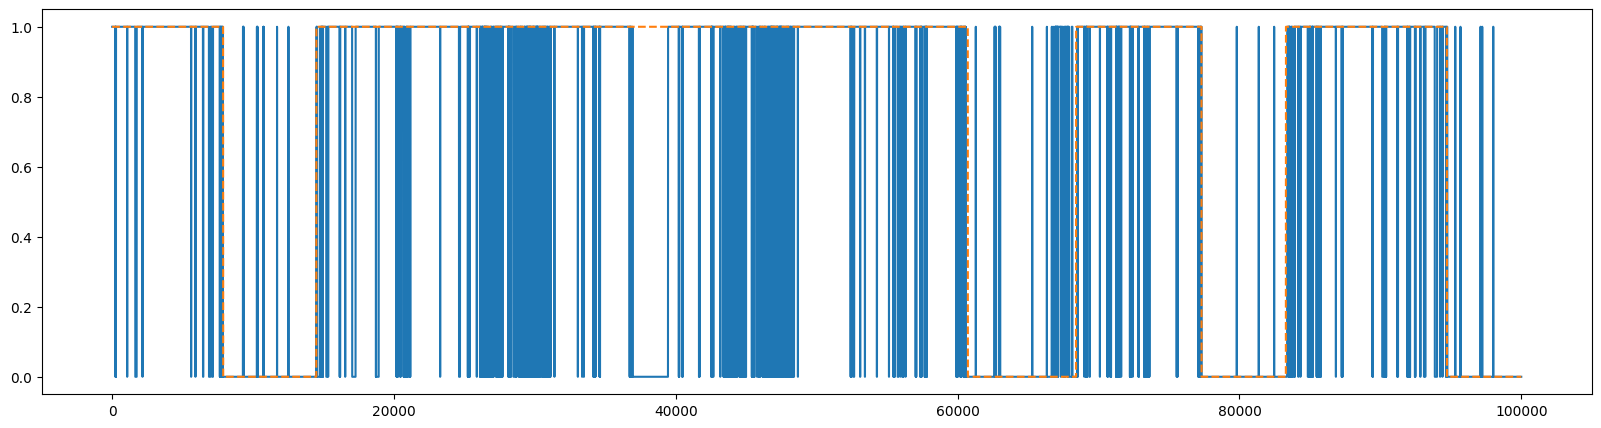

In [164]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(participant_series['step'], participant_series['prediction_class'])
plt.plot(participant_series['step'], participant_series['awake'], linestyle='dashed')
plt.show()

In [165]:
fig = px.line(participant_series, x='step', y='prediction_confidence_1', title=f'Schlafdaten für {participant_series_id}')
for index, row in participant_events.dropna().iterrows():
    color = 'orange' if row.event == 'onset' else 'red' 
    fig.add_vline(x=row.step, line_width=1, line_dash='dash', line_color=color)
    
for index, row in participant_true_events.dropna().iterrows():
    color = 'orange' if row.event == 'onset' else 'red' 
    fig.add_vline(x=row.step, line_width=1, line_color=color)

#Custom Legend
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        line=dict(color='orange', width=2, dash='dash'),
        name="onset event",
    )
)
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        line=dict(color='red', width=2, dash='dash'),
        name="wakeup event",
    )
)
fig.update_layout(legend_title="Events")
    
fig.show()